# Testing functions from little_hawk repo

This notebook contains a copy of some of the functions from the repo little_hawk, tests of these functions and plotting of results. The last sections aims at creating tools to smooth the functions even more, using a rolling mean, in order to have less hectic derivatives.

The derivatives being very sensitive to noise and thus unstable tools, this approach was finally set aside.

In [1]:
import xarray as xr
import dask.array
import matplotlib.pyplot as plt

## Import functions from repo

In [2]:
def median_spacetime_filtering(ds, min_periods_val, time_window=11, x_span=11, y_span=11):
    '''
    Function to apply median filtering in time and space
    Args:
        ds: clean data dataset
        time_window: time windo on which to apply median filter [index]
        x_span: x-span on which to apply filtering, unit [index]
        y_span: y-span on which to apply filtering, unit [index]
    Returns:
    '''
    ds['snow_surface'] = ds['mean'].rolling(time=time_window, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in time with a window of {time_window}')
    ds['snow_surface'] = ds['snow_surface'].rolling({'x': x_span, 'y': y_span}, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in space with a window [{x_span}, {y_span}]')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()

In [3]:
def compute_time_derivatives(ds):
    '''
    Function to compute 1st and 2nd derivative of the snow surface height along the time axis
    Args:
        ds (xarray dataset): dataset containing snow surface data organized in ['time', 'y', 'x']
    Returns:
        A xarray dataset with the first and second order derivative
    '''
    grad1 = dask.array.gradient(ds['snow_surface'], axis=0, edge_order=1)
    grad2 = dask.array.gradient(grad1, axis=0, edge_order=1)

    gradients = ds.drop_vars(list(ds.keys()))
    gradients['first'] = (['time', 'y', 'x'], grad1)
    gradients['second'] = (['time', 'y', 'x'], grad2)
    print('---> Time derivatives computed')
    return gradients

## Create dataset and access data

In [4]:
day1 = xr.open_dataset("20220101.nc")

In [5]:
day1.isel(x=100, y=50, time=34)

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     datetime64[ns] 2022-01-01T09:00:00
    x        float64 -9.95
    y        float64 -0.45
Data variables:
    count    float64 ...
    idw      float64 ...
    max      float64 ...
    mean     float64 ...
    min      float64 ...
    stdev    float64 ...
Attributes:
    transform:     [  0.1   0.  -20.    0.   -0.1   4.6]
    res:           [0.1 0.1]
    is_tiled:      0
    nodatavals:    [-9999. -9999. -9999. -9999. -9999. -9999.]
    scales:        [1. 1. 1. 1. 1. 1.]
    offsets:       [0. 0. 0. 0. 0. 0.]
    descriptions:  ['min', 'max', 'mean', 'idw', 'count', 'stdev']

In [6]:
# Add snow_surface variable to dataset
median_spacetime_filtering(day1, 3)

---> Median filtering in time with a window of 11
---> Median filtering in space with a window [11, 11]


In [7]:
day1['snow_surface'].isel(x=100, y=50)

<xarray.DataArray 'snow_surface' (time: 92)>
array([-0.84614826, -0.84625   , -0.84638081, -0.84651163, -0.84666851,
       -0.8468254 , -0.84732143, -0.84843137, -0.84887097, -0.84949153,
       -0.84949153, -0.84949153, -0.850625  , -0.85066667, -0.85066667,
       -0.850625  , -0.850625  , -0.850625  , -0.850625  , -0.84888889,
       -0.84888889, -0.84903846, -0.84903846, -0.84903846, -0.84903846,
       -0.85083333, -0.85092308, -0.85136364, -0.85136364, -0.85136364,
       -0.85140351, -0.85175439, -0.85175439, -0.85175439, -0.85175439,
       -0.85140351, -0.85065217, -0.85065217, -0.850625  , -0.85068182,
       -0.85068182, -0.850625  , -0.85      , -0.85      , -0.85      ,
       -0.85      , -0.84878049, -0.84870968, -0.84548387, -0.84548387,
       -0.8444186 , -0.84434783, -0.8428    , -0.8426    , -0.83792453,
       -0.83880952, -0.84      , -0.84134615, -0.84255814, -0.8426    ,
       -0.83948276, -0.83880952, -0.83880952, -0.83880952, -0.83851852,
       -0.83851852, -0.83617021, -0.82606557, -0.81851064, -0.79903226,
       -0.78770833, -0.7875    , -0.78561404, -0.782     , -0.77548387,
       -0.77361702, -0.772     , -0.76326923, -0.75982759, -0.75773585,
       -0.75614035, -0.7521875 , -0.75104167, -0.7509375 , -0.7490566 ,
       -0.74839286, -0.74705882, -0.74614892, -0.74607143, -0.74382353,
       -0.74142857, -0.73901216])
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:45:00
    x        float64 -9.95
    y        float64 -0.45

In [8]:
day1['mean'].isel(x=12, y=50)

<xarray.DataArray 'mean' (time: 92)>
array([-2.253235, -2.247838, -2.233333, -2.258966, -2.268333, -2.243462,
       -2.27    , -2.255556, -2.263462, -2.259167, -2.24875 , -2.243529,
       -2.25    , -2.252895, -2.276071, -2.272857, -2.265172, -2.29093 ,
       -2.263429, -2.271111, -2.246061, -2.2575  , -2.26425 , -2.297037,
       -2.255   , -2.249091, -2.245   , -2.266905, -2.26875 , -2.2615  ,
       -2.247222, -2.253846, -2.244828, -2.255   , -2.262759, -2.248667,
       -2.263415, -2.259111, -2.270667, -2.2484  , -2.243929, -2.269412,
       -2.248   , -2.269524, -2.268462, -2.242222, -2.236364, -2.255128,
       -2.26575 , -2.246923, -2.242   , -2.192727,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan])
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:45:00
    x        float64 -18.75
    y        float64 -0.45

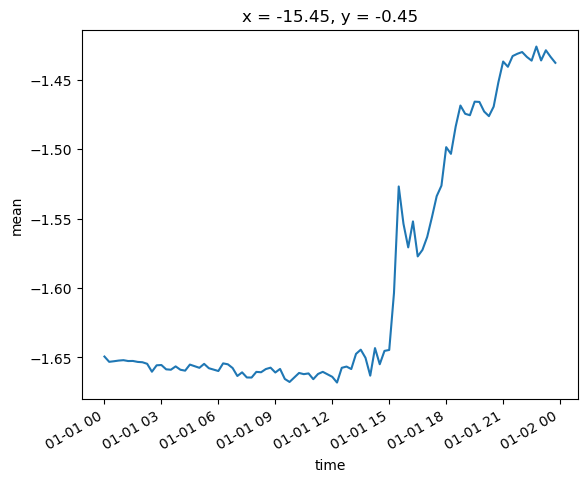

In [9]:
day1['mean'].isel(x=45, y=50).plot()

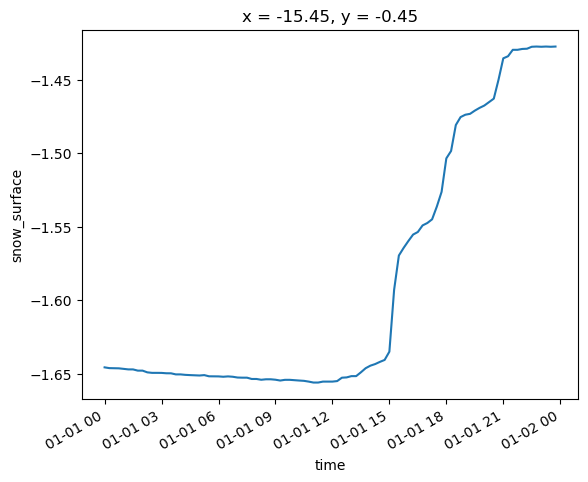

In [10]:
day1['snow_surface'].isel(x=45, y=50).plot()

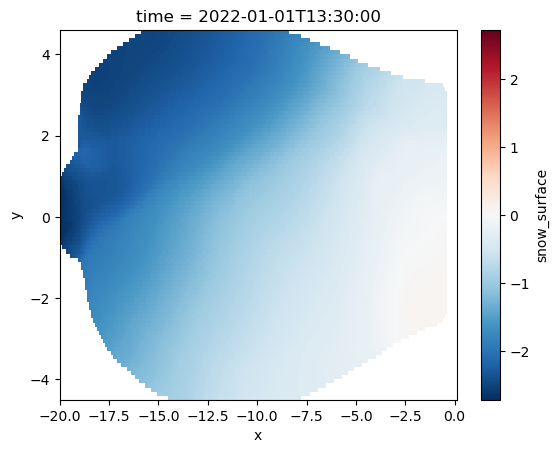

In [11]:
day1['snow_surface'].isel(time=50).plot()

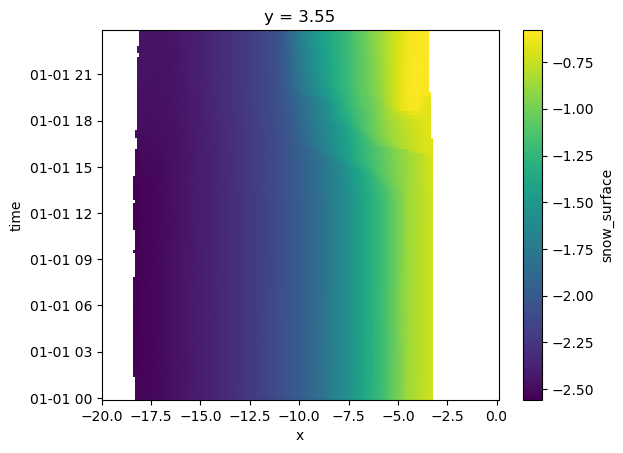

In [12]:
day1['snow_surface'].isel(y=10).plot()

## Apply gradients procedure and access new data

In [13]:
gradients_day1 = compute_time_derivatives(day1)
# gradients_day1

---> Time derivatives computed


In [14]:
gradients_day1

<xarray.Dataset>
Dimensions:  (time: 92, x: 201, y: 91)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:45:00
  * x        (x) float64 -19.95 -19.85 -19.75 -19.65 ... -0.25 -0.15 -0.05 0.05
  * y        (y) float64 4.55 4.45 4.35 4.25 4.15 ... -4.15 -4.25 -4.35 -4.45
Data variables:
    first    (time, y, x) float64 dask.array<chunksize=(92, 91, 201), meta=np.ndarray>
    second   (time, y, x) float64 dask.array<chunksize=(92, 91, 201), meta=np.ndarray>
Attributes:
    transform:     [  0.1   0.  -20.    0.   -0.1   4.6]
    res:           [0.1 0.1]
    is_tiled:      0
    nodatavals:    [-9999. -9999. -9999. -9999. -9999. -9999.]
    scales:        [1. 1. 1. 1. 1. 1.]
    offsets:       [0. 0. 0. 0. 0. 0.]
    descriptions:  ['min', 'max', 'mean', 'idw', 'count', 'stdev']

In [15]:
gradients_val = gradients_day1['first']

In [16]:
grad_plot = gradients_val.isel(x=12, y=50)
grad_plot

<xarray.DataArray 'first' (time: 92)>
dask.array<getitem, shape=(92,), dtype=float64, chunksize=(92,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:45:00
    x        float64 -18.75
    y        float64 -0.45

## Plot data

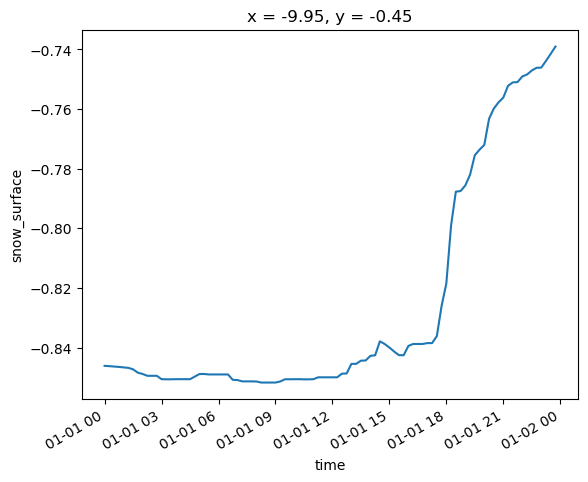

In [17]:
day1['snow_surface'].isel(x=100, y=50).plot()

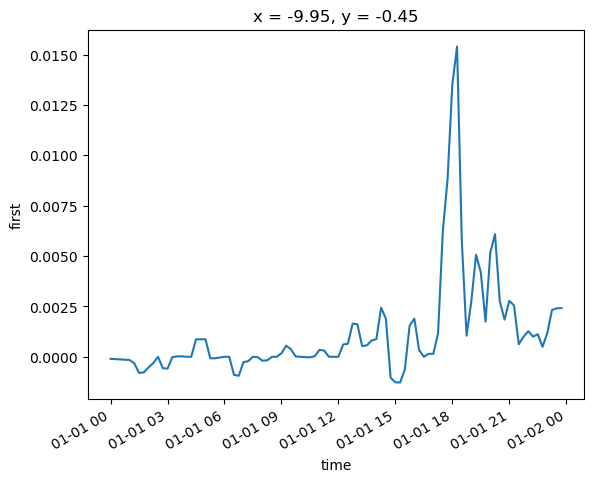

In [18]:
gradients_day1['first'].isel(x=100, y=50).plot()

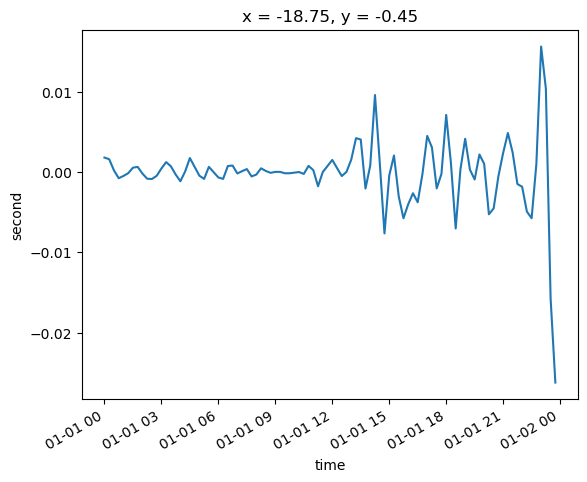

In [19]:
gradients_day1['second'].isel(x=12, y=50).plot()

## Trying similar process with day 2

In [20]:
ds = xr.open_mfdataset('20220102.nc')

### Almost all values in ds\['mean'\] are nan

In [21]:
ds['mean'].isel(x=12).values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [22]:
ds['mean'].isel(time=12).values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [23]:
ds['mean'].isel(y=12).values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [24]:
# for i in ds['mean'].isel(x=12).values:
    # if str(i) != 'nan':
        # print(i)

### Try running the code nonetheless

In [25]:
# Add snow_surface variable to dataset
median_spacetime_filtering(ds, 3)

---> Median filtering in time with a window of 11
---> Median filtering in space with a window [11, 11]


In [26]:
snow_array = xr.DataArray(ds['snow_surface'].isel(x=12, y=50).values)

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


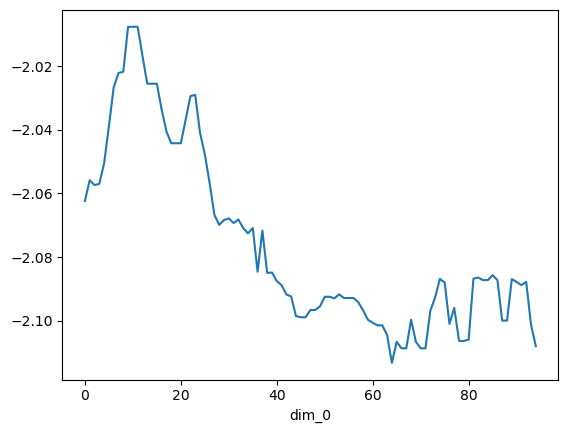

In [27]:
snow_array.plot()

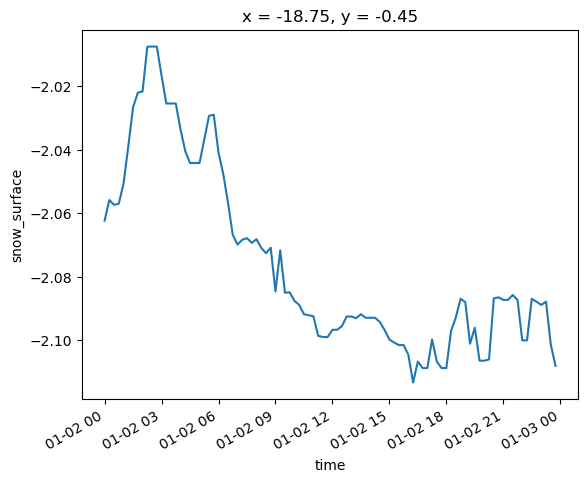

In [28]:
# ds['mean'].isel(x=45, y=50).plot(color='red', marker='v', linestyle='None')
ds['snow_surface'].isel(x=12, y=50).plot()

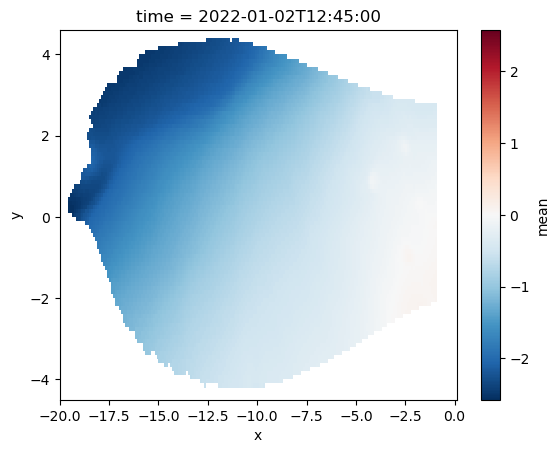

In [29]:
ds['mean'].isel(time=50).plot()

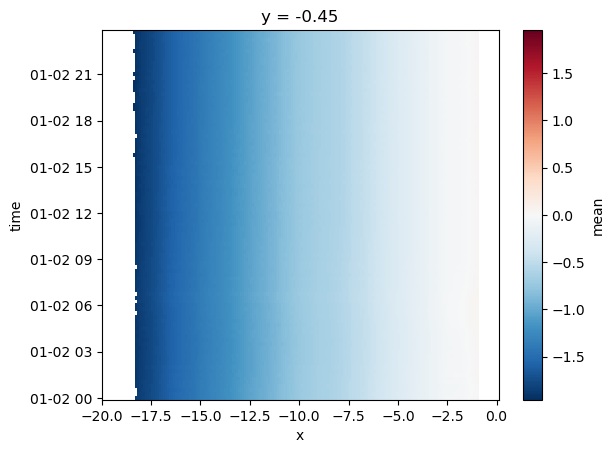

In [30]:
ds['mean'].isel(y=50).plot()

## Combining days 1 and 2 for different values of min_periods

In [31]:
ds_1 = xr.open_mfdataset('2022*.nc', chunks={'x': 20,'y': 20, 'time': 1})

In [32]:
median_spacetime_filtering(ds_1, 1)

---> Median filtering in time with a window of 11
---> Median filtering in space with a window [11, 11]


In [33]:
#ds['mean'].isel(x=45, y=50).plot()

In [34]:
#ds['snow_surface']

In [35]:
#ds.isel(x=10)

In [36]:
ds_1.unify_chunks()

,Array,Chunk
Bytes,26.10 MiB,3.12 kiB
Shape,"(187, 91, 201)","(1, 20, 20)"
Count,87518 Tasks,33660 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,26.10 MiB,3.12 kiB
Shape,"(187, 91, 201)","(1, 20, 20)"
Count,87518 Tasks,33660 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [37]:
gradients_1 = compute_time_derivatives(ds_1)

---> Time derivatives computed


In [38]:
ds_2 = xr.open_mfdataset('2022*.nc', chunks={'x': 20,'y': 20, 'time': 1})
median_spacetime_filtering(ds_2, 2)
ds_2.unify_chunks()
gradients_2 = compute_time_derivatives(ds_2)

---> Median filtering in time with a window of 11
---> Median filtering in space with a window [11, 11]
---> Time derivatives computed


In [39]:
ds_4 = xr.open_mfdataset('2022*.nc', chunks={'x': 20,'y': 20, 'time': 1})
median_spacetime_filtering(ds_4, 4)
ds_4.unify_chunks()
gradients_4 = compute_time_derivatives(ds_4)

---> Median filtering in time with a window of 11
---> Median filtering in space with a window [11, 11]
---> Time derivatives computed


In [40]:
ds_9 = xr.open_mfdataset('2022*.nc', chunks={'x': 20,'y': 20, 'time': 1})
median_spacetime_filtering(ds_9, 9)
ds_9.unify_chunks()
gradients_9 = compute_time_derivatives(ds_9)

---> Median filtering in time with a window of 11
---> Median filtering in space with a window [11, 11]
---> Time derivatives computed


In [41]:
ds_11 = xr.open_mfdataset('2022*.nc', chunks={'x': 20,'y': 20, 'time': 1})
median_spacetime_filtering(ds_11, 11)
ds_11.unify_chunks()
gradients_11 = compute_time_derivatives(ds_11)

---> Median filtering in time with a window of 11
---> Median filtering in space with a window [11, 11]
---> Time derivatives computed


### Plotting data for different values of of min_periods

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


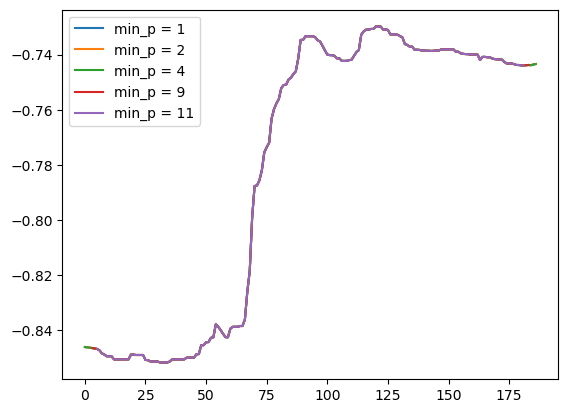

In [42]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
ax.plot(ds_1['snow_surface'].isel(x=100, y=50), label='min_p = 1')
ax.plot(ds_2['snow_surface'].isel(x=100, y=50), label='min_p = 2')
ax.plot(ds_4['snow_surface'].isel(x=100, y=50), label='min_p = 4')
ax.plot(ds_9['snow_surface'].isel(x=100, y=50), label='min_p = 9')
ax.plot(ds_11['snow_surface'].isel(x=100, y=50), label='min_p = 11')
ax.legend()

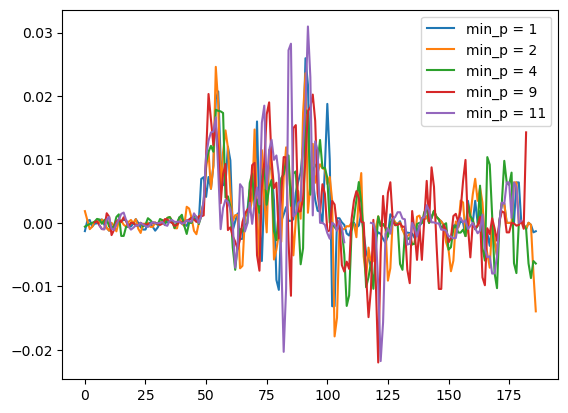

In [43]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
ax.plot(gradients_1['first'].isel(x=12, y=50), label='min_p = 1')
ax.plot(gradients_2['first'].isel(x=12, y=50), label='min_p = 2')
ax.plot(gradients_4['first'].isel(x=12, y=50), label='min_p = 4')
ax.plot(gradients_9['first'].isel(x=12, y=50), label='min_p = 9')
ax.plot(gradients_11['first'].isel(x=12, y=50), label='min_p = 11')
ax.legend()

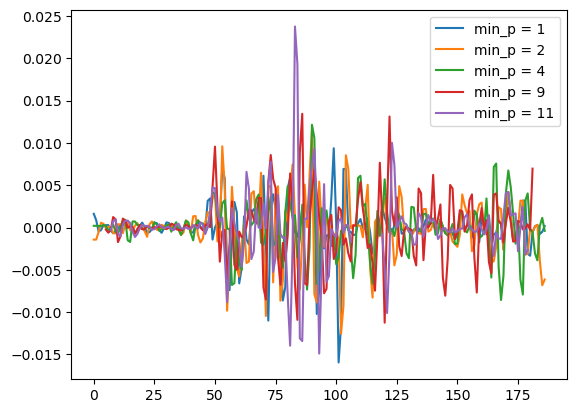

In [44]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
ax.plot(gradients_1['second'].isel(x=12, y=50), label='min_p = 1')
ax.plot(gradients_2['second'].isel(x=12, y=50), label='min_p = 2')
ax.plot(gradients_4['second'].isel(x=12, y=50), label='min_p = 4')
ax.plot(gradients_9['second'].isel(x=12, y=50), label='min_p = 9')
ax.plot(gradients_11['second'].isel(x=12, y=50), label='min_p = 11')
ax.legend()

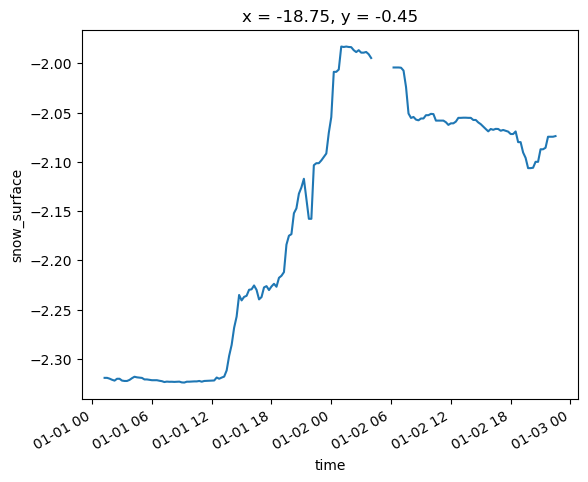

In [45]:
ds_11['snow_surface'].isel(x=12, y=50).plot()

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


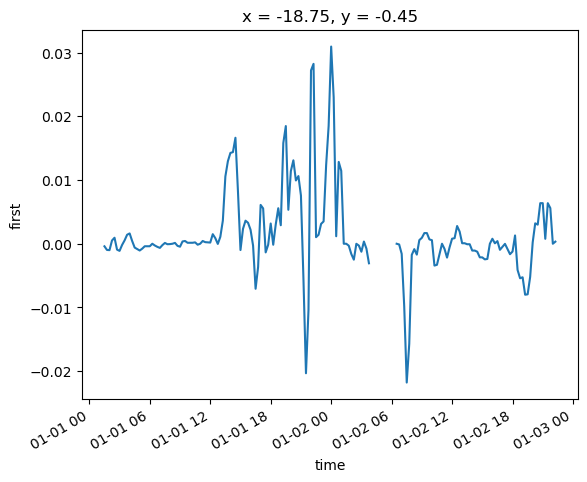

In [46]:
gradients_11['first'].isel(x=12, y=50).plot()

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


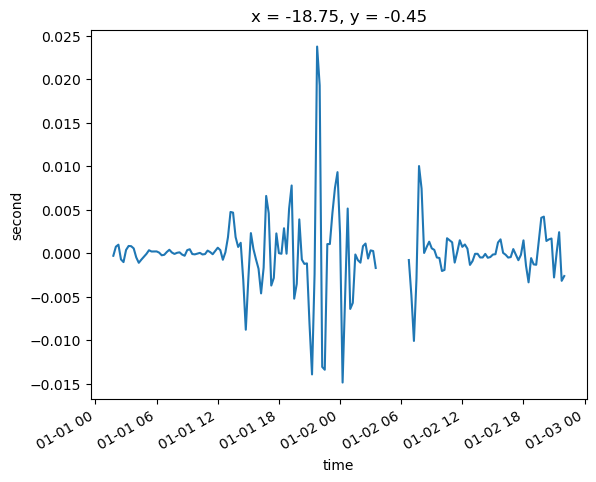

In [47]:
gradients_11['second'].isel(x=12, y=50).plot()

## Trying to smooth out the signal even more

In [48]:
def mean_time_filtering(ds, time_window=11):
    '''
    Function to apply mean filtering in time
    Args:
        ds: clean data dataset
        time_window: time window on which to apply mean filter [index]
    Returns:
    '''
    ds['snow_surface_smoothed'] = ds['snow_surface'].rolling(time=time_window, min_periods=7, center=True).mean()
    print(f'---> Mean filtering in time with a window of {time_window}')

In [49]:
mean_time_filtering(ds_1)

---> Mean filtering in time with a window of 11


In [50]:
mean_time_filtering(day1)

---> Mean filtering in time with a window of 11


/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


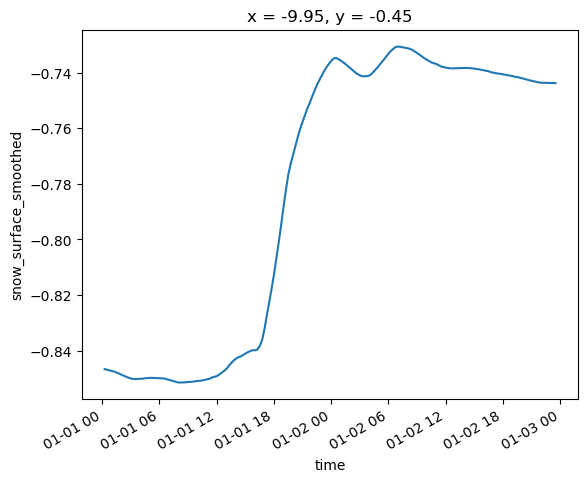

In [51]:
ds_1['snow_surface_smoothed'].isel(x=100, y=50).plot()

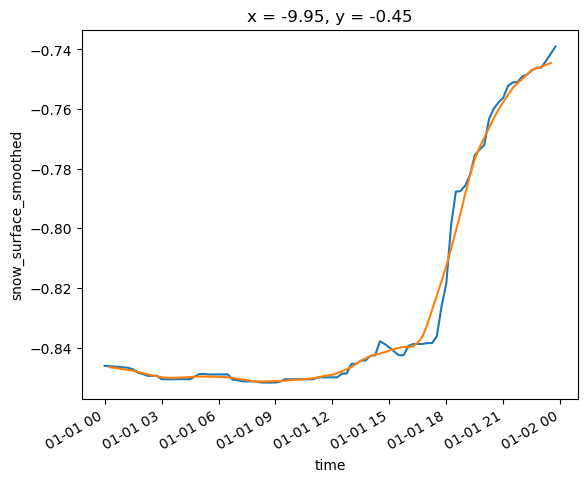

In [52]:
day1['snow_surface'].isel(x=100, y=50).plot()
day1['snow_surface_smoothed'].isel(x=100, y=50).plot()

In [53]:
def compute_time_derivatives_smoothed(ds):
    '''
    Function to compute 1st and 2nd derivative of the snow surface height along the time axis
    Args:
        ds (xarray dataset): dataset containing snow surface data after mean smoothing organized in ['time', 'y', 'x']
    Returns:
        A xarray dataset with the first and second order derivative
    '''
    grad1 = dask.array.gradient(ds['snow_surface_smoothed'], axis=0, edge_order=1)
    grad2 = dask.array.gradient(grad1, axis=0, edge_order=1)

    gradients = ds.drop_vars(list(ds.keys()))
    gradients['first'] = (['time', 'y', 'x'], grad1)
    gradients['second'] = (['time', 'y', 'x'], grad2)
    print('---> Time derivatives computed')
    return gradients

In [54]:
gradients_smoothed = compute_time_derivatives_smoothed(ds_1)

---> Time derivatives computed


/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


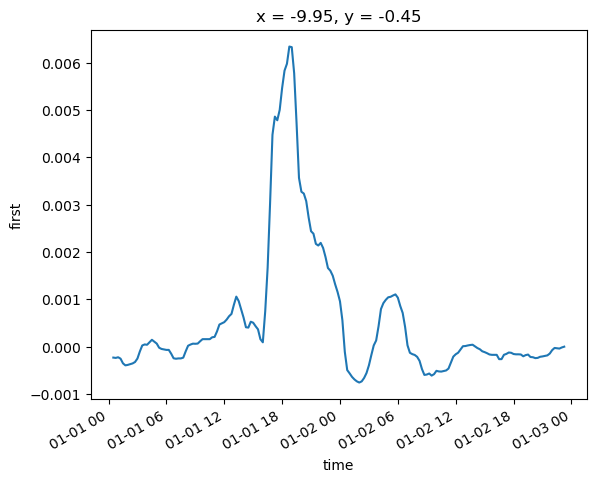

In [55]:
gradients_smoothed['first'].isel(x=100, y=50).plot()

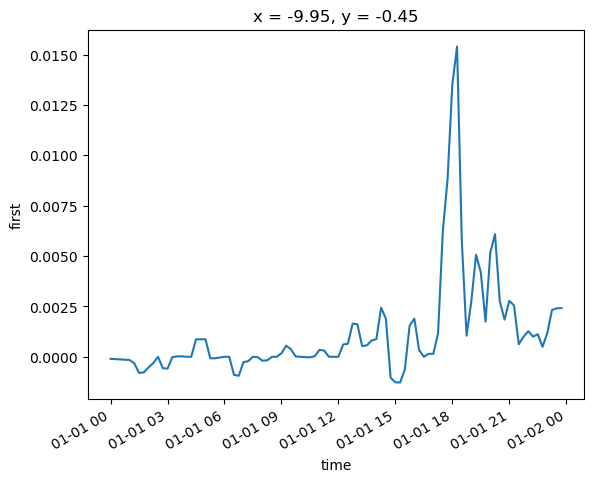

In [56]:
gradients_day1['first'].isel(x=100, y=50).plot()

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


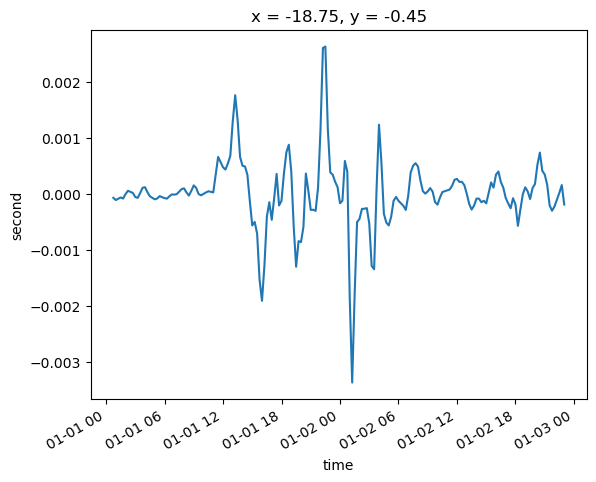

In [57]:
gradients_smoothed['second'].isel(x=12, y=50).plot()

### Smoothing the derivative

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


(array([8.000000e+00, 3.100000e+01, 6.791000e+03, 2.793700e+04,
        2.226430e+05, 2.350228e+06, 8.843400e+04, 5.922000e+03,
        3.400000e+01, 9.000000e+00]),
 array([-0.00326412, -0.00264395, -0.00202379, -0.00140362, -0.00078345,
        -0.00016329,  0.00045688,  0.00107704,  0.00169721,  0.00231738,
         0.00293754]),
 <BarContainer object of 10 artists>)

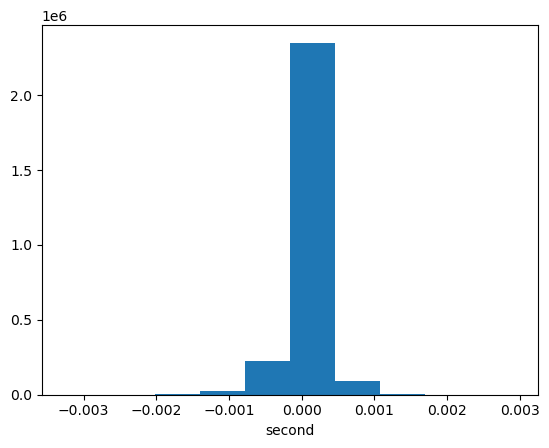

In [58]:
grad2_smoothed = gradients_smoothed['second'].rolling(time=11, min_periods=7, center=True).mean()
grad2_smoothed.plot()

In [86]:
data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_redone_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing numbe

In [87]:
data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb.nc')

In [88]:
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb.nc')

In [89]:
data_dec_jan_feb = data_dec_jan_feb.ffill(dim='time')

In [90]:
data_dec_jan_feb

<xarray.Dataset>
Dimensions:  (time: 4228, x: 22, y: 22)
Coordinates:
  * time     (time) datetime64[ns] 2021-12-06T13:15:00 ... 2022-02-20T20:30:00
  * x        (x) float64 -9.95 -9.85 -9.75 -9.65 ... -8.15 -8.05 -7.95 -7.85
  * y        (y) float64 0.05 -0.05 -0.15 -0.25 ... -1.75 -1.85 -1.95 -2.05
Data variables:
    count    (time, y, x) float64 51.0 56.0 54.0 52.0 ... 84.0 87.0 93.0 90.0
    idw      (time, y, x) float64 -1.143 -1.126 -1.114 ... -0.3229 -0.3204
    max      (time, y, x) float64 -1.11 -1.1 -1.08 -1.06 ... -0.24 -0.2 -0.2
    mean     (time, y, x) float64 -1.143 -1.126 -1.114 ... -0.322 -0.3219 -0.319
    min      (time, y, x) float64 -1.17 -1.17 -1.15 -1.13 ... -0.44 -0.44 -0.45
    stdev    (time, y, x) float64 0.0158 0.01475 0.01705 ... 0.03864 0.04211
Attributes:
    transform:     [  0.1   0.  -20.    0.   -0.1   4.6]
    res:           [0.1 0.1]
    is_tiled:      0
    nodatavals:    [-9999. -9999. -9999. -9999. -9999. -9999.]
    scales:        [1. 1. 1. 1. 1. 1.]
    offsets:       [0. 0. 0. 0. 0. 0.]
    descriptions:  ['min', 'max', 'mean', 'idw', 'count', 'stdev']

In [107]:
data_dec_jan_feb.coords.dims.keys()

KeysView(Frozen({'time': 4228, 'x': 22, 'y': 22}))

In [91]:
median_spacetime_filtering(data_dec_jan_feb, 11)

---> Median filtering in time with a window of 11
---> Median filtering in space with a window [11, 11]


In [92]:
mean_time_filtering(data_dec_jan_feb, 71)

---> Mean filtering in time with a window of 71


In [93]:
gradients_dec_jan_feb = compute_time_derivatives(data_dec_jan_feb)

---> Time derivatives computed


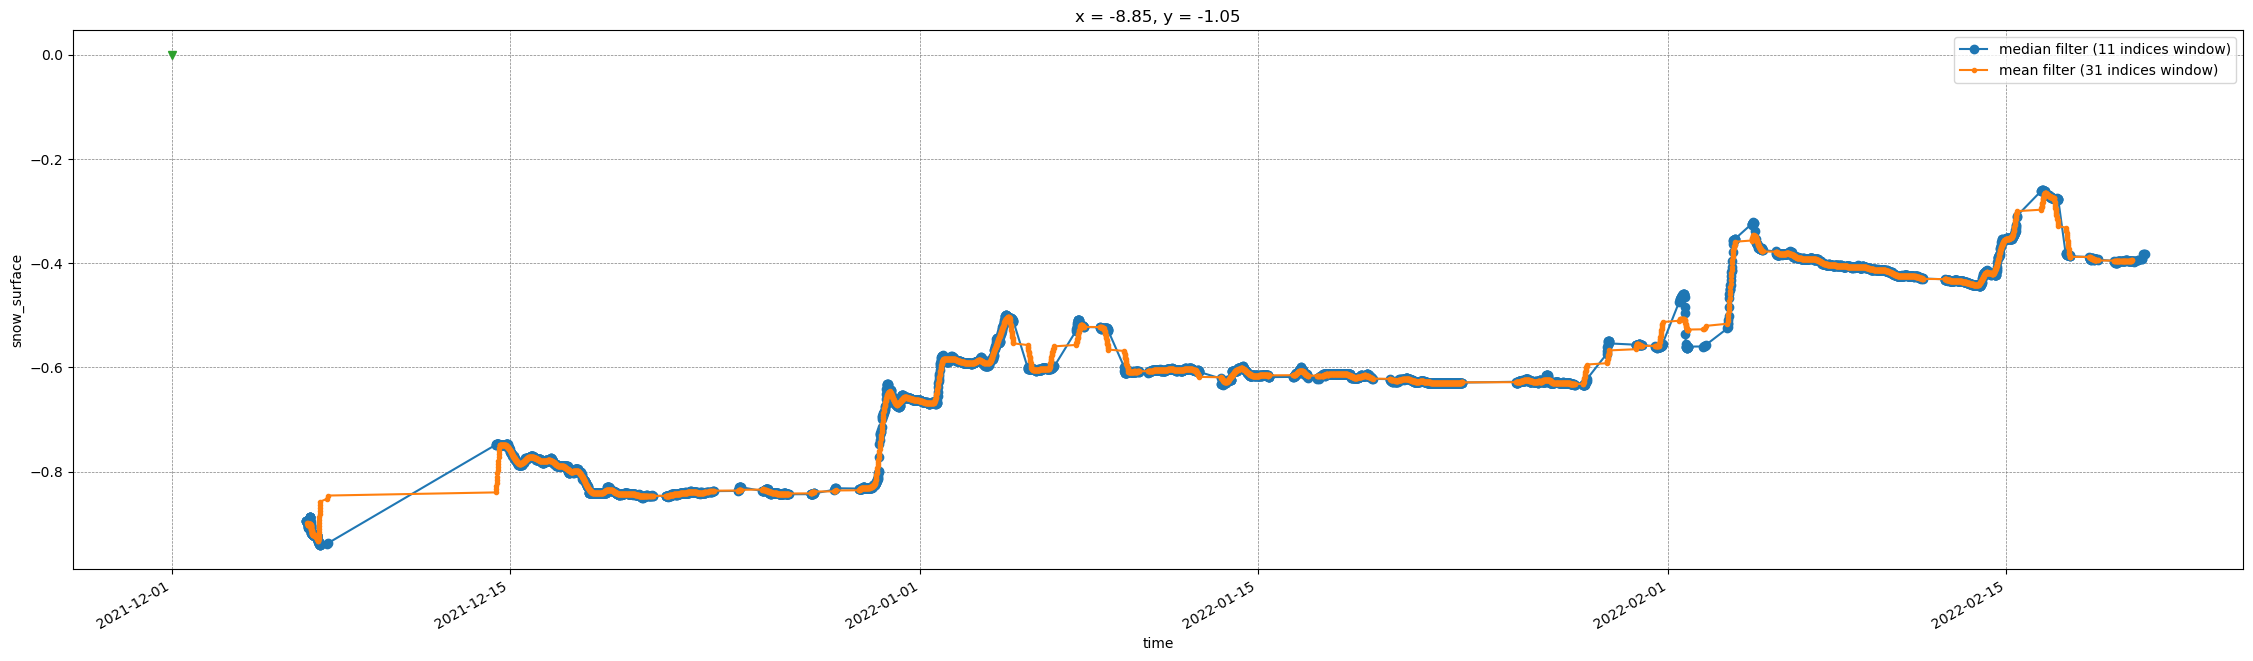

In [142]:
data_dec_jan_feb['snow_surface'].isel(x=11, y=11).plot(figsize=(28, 7), label='median filter (11 indices window)', marker='o')
data_dec_jan_feb['snow_surface'].isel(x=11, y=11).rolling(time=31, center=True).mean().plot(label='mean filter (31 indices window)', marker='.')
plt.plot(18962, 0, marker='v') # artificially add December 1st (empirical index) to be on the same scale as other met plots
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
#plt.savefig("snow_depth_data_dec_jan_feb.png")

In [73]:
time = data_dec_jan_feb[time].isel(x=11, y=11)

NameError: name 'time' is not defined

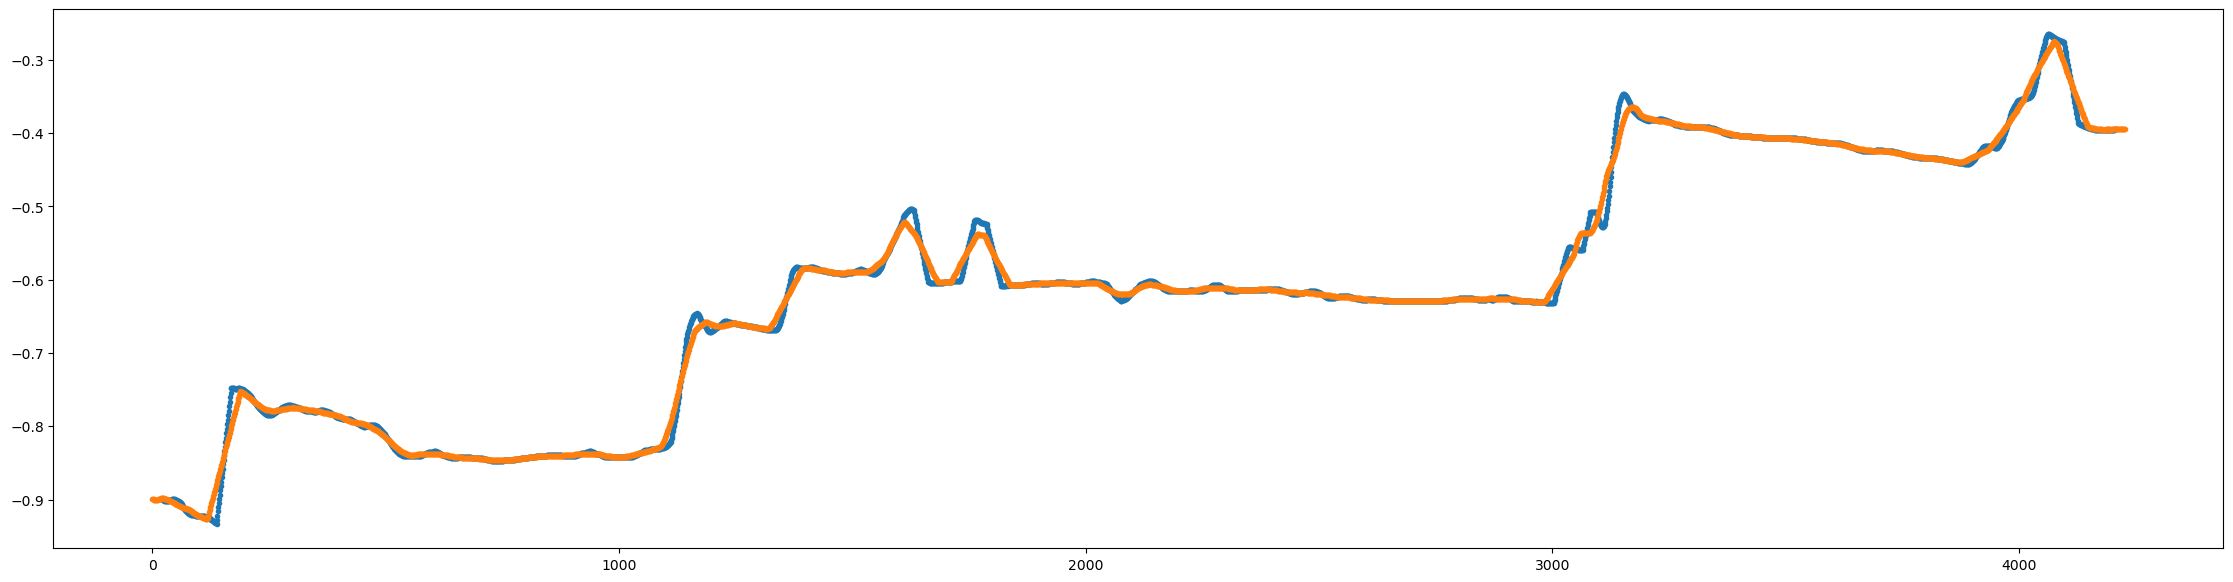

In [138]:
plt.figure(figsize=(28, 7))
plt.plot(data_dec_jan_feb['snow_surface'].isel(x=11, y=11).rolling(time=31, center=True).mean(), linestyle='None', marker='.')
plt.plot(data_dec_jan_feb['snow_surface_smoothed'].isel(x=11, y=11), linestyle='None', marker='.')

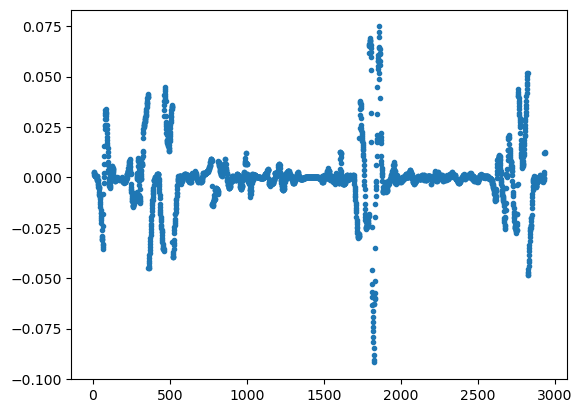

In [69]:
plt.plot(data_dec_jan_feb['snow_surface'].isel(x=11, y=11)-data_dec_jan_feb['snow_surface_smoothed'].isel(x=11, y=11), linestyle='None', marker='.')


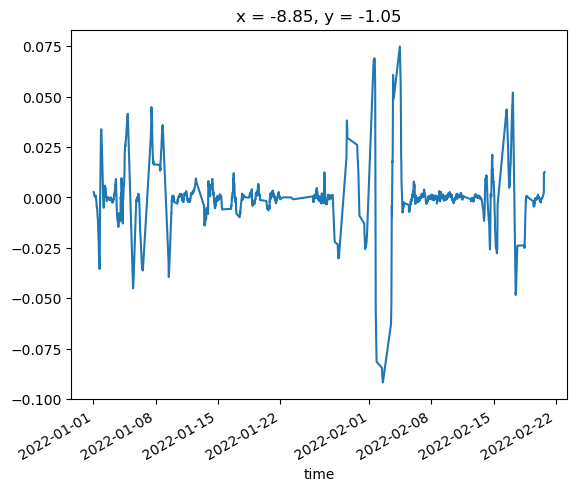

In [70]:
(data_dec_jan_feb['snow_surface'].isel(x=11, y=11)-data_dec_jan_feb['snow_surface_smoothed'].isel(x=11, y=11)).plot()